In [15]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [3]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [4]:
df_small

,One,Two,Three,Four,Five,Six,Seven,Eight
1,1,1,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,1,0,1,0,0,0,1,0
5,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9996,0,0,1,0,0,0,0,0
9997,1,0,1,0,0,0,1,1
9998,0,0,0,0,0,0,1,0
9999,1,0,0,0,0,0,1,0


In [5]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [6]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [7]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Sorting Functions

In [8]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [9]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

### 1st order CI

In [10]:
#1st order CI
def cond_1_generate(df, rho):
    v = list(df)
    p_permutations = list(itertools.permutations(v,3))
    order_0 = create_permutations(chi2bool(df, rho)[0])
    generated = [x for x in p_permutations if x[:2] not in order_0]
    generated_0 = set(tuple(sorted(items[:2])) for items in generated)
    generate_return = [x for x in generated if x[:2] in generated_0]
    return generate_return

In [11]:
def cond_1_test(df, rho):
    chi2_data = []
    phi = cond_1_generate(df, rho)
    for i,j,k in phi:
        chi2 = chi_square(X=i, Y=j, Z=[k], data=df, significance_level=rho)
        chi2_data.append((i,j,k,chi2))
    true_list = [x for x in chi2_data if True in x]
    false_list = [x for x in chi2_data if False in x]
    return true_list, false_list

### CONDITIONAL MAIN CODE

In [12]:
def PC_(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1, p_2, p_3 = [x[:1] for x in list_permutations], [x[1:2] for x in list_permutations], [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p_3):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#1st order CI takes 2minutes to run
#2nd order CI 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

In [77]:
G = nx.Graph()
v = list(df_small)
for i in v:
    G.add_node(i)
print(G)

Graph with 8 nodes and 0 edges


In [78]:
k = list(itertools.combinations(v,2))
for i,j in k:
    G.add_edge(i,j)

Graph with 8 nodes and 28 edges


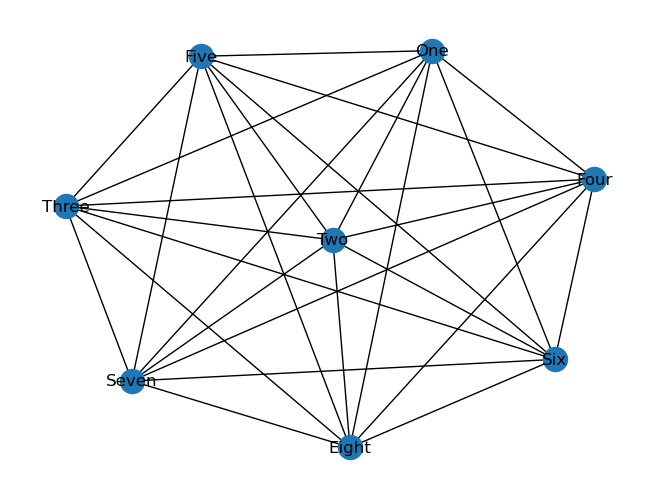

In [79]:
print(G)
nx.draw(G, with_labels = True)

In [82]:
ind_0 = [x[:2] for x in chi2bool(df_small, 0.05)[0]]
# ind_0

In [83]:
for i,j in ind_0:
    G.remove_edge(i,j)

Graph with 8 nodes and 20 edges


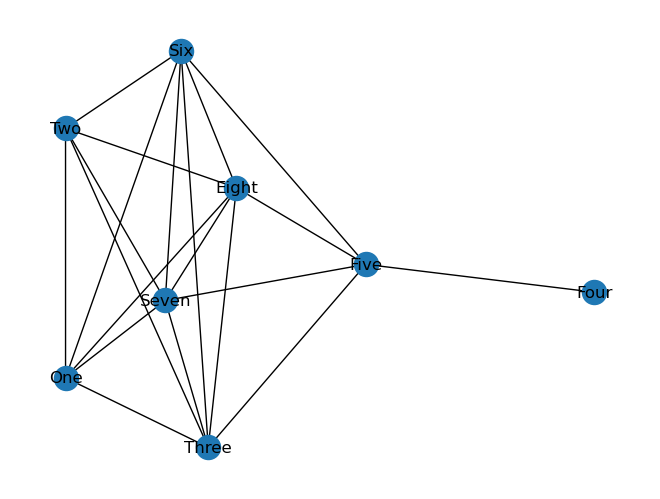

In [133]:
print(G)
nx.draw(G, with_labels = True)

In [86]:
false_list = [x[:2] for x in chi2bool(df_small, 0.05)[1]]

In [136]:
test_list = []
for i,j in false_list:
    test_list.append((i, j, list(G.edges(i)), list(G.edges(j))))

In [138]:
test_list

[('One',
  'Two',
  [('One', 'Two'),
   ('One', 'Three'),
   ('One', 'Six'),
   ('One', 'Seven'),
   ('One', 'Eight')],
  [('Two', 'One'),
   ('Two', 'Three'),
   ('Two', 'Six'),
   ('Two', 'Seven'),
   ('Two', 'Eight')]),
 ('One',
  'Three',
  [('One', 'Two'),
   ('One', 'Three'),
   ('One', 'Six'),
   ('One', 'Seven'),
   ('One', 'Eight')],
  [('Three', 'One'),
   ('Three', 'Two'),
   ('Three', 'Five'),
   ('Three', 'Six'),
   ('Three', 'Seven'),
   ('Three', 'Eight')]),
 ('One',
  'Six',
  [('One', 'Two'),
   ('One', 'Three'),
   ('One', 'Six'),
   ('One', 'Seven'),
   ('One', 'Eight')],
  [('Six', 'One'),
   ('Six', 'Two'),
   ('Six', 'Three'),
   ('Six', 'Five'),
   ('Six', 'Seven'),
   ('Six', 'Eight')]),
 ('One',
  'Seven',
  [('One', 'Two'),
   ('One', 'Three'),
   ('One', 'Six'),
   ('One', 'Seven'),
   ('One', 'Eight')],
  [('Seven', 'One'),
   ('Seven', 'Two'),
   ('Seven', 'Three'),
   ('Seven', 'Five'),
   ('Seven', 'Six'),
   ('Seven', 'Eight')]),
 ('One',
  'Eight',
  [(

In [156]:
n = 0
N = 3
while n < N:
    X, Y = test_list[n][0], test_list[n][1]
    k_0, k_1 = test_list[n][2], test_list[n][3]
    edge_0 = [x for x in k_0 if x[1] not in (y[1] for y in k_1) and x[1] != Y]
    edge_1 = [x for x in k_1 if x[1] not in (y[1] for y in k_0) and x[1] != X]
    print(X, Y)
#     print(k_0)
#     print(k_1)
    print(edge_0)
    print(edge_1)
    n += 1

One Two
[]
[]
One Three
[]
[('Three', 'Five')]
One Six
[]
[('Six', 'Five')]


In [103]:
list(G.edges('One', 'Three'))

[('One', 'Two', None),
 ('One', 'Three', None),
 ('One', 'Six', None),
 ('One', 'Seven', None),
 ('One', 'Eight', None)]

### small network

In [ ]:
%%time
n = 0
N = 1
chi_list = []
m = Gobnilp()
while n < N:
    empty_list = []
    m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat')
    for i,j in m.adjacency.items():
        if j.X == 1.0: #j.X == 1.0 implies there is an edge between the nodes
            empty_list.append(i)
    #chi2 test
    empty_list = [list(x) for x in empty_list]
    phi_0, phi_1 = [x[0] for x in empty_list], [x[1] for x in empty_list]
    for i,j in zip(phi_0, phi_1):
        chi2 = chi_square(X=i, Y=j, Z=[], data=df_medium, significance_level=0.05)
        chi_list.append((i,j,chi2))
    true_list = [x[:2] for x in chi_list if True in x]
    for i,j in true_list:
        m.add_obligatory_independence([i],[j])
    n += 1

In [ ]:
%%time
n = 0
N = 1
chi_list = []
m = Gobnilp()
while n < N:
    empty_list = []
    m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')
    for i,j in m.adjacency.items():
        if j.X == 1.0: #j.X == 1.0 implies there is an edge between the nodes
            empty_list.append(i)
    #chi2 test
    empty_list = [list(x) for x in empty_list]
    phi_0, phi_1 = [x[0] for x in empty_list], [x[1] for x in empty_list]
    for i,j in zip(phi_0, phi_1):
        chi2 = chi_square(X=i, Y=j, Z=[], data=df_small, significance_level=0.05)
        chi_list.append((i,j,chi2))
    true_list = [x[:2] for x in chi_list if True in x]
    for i,j in true_list:
        m.add_obligatory_independence([i],[j])
    n += 1

In [ ]:
new_list = [x for x in chi2bool(df_small, 0.4)]
new_list

In [ ]:
%%time
chi_list = [x[:2] for x in chi2bool(df_small, 0.4)[0]]
m_small = Gobnilp()
for i,j in chi_list:
    m_small.add_forbidden_adjacency((i,j))
m_small.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')

In [ ]:
m_small.adjacency

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Five:Two][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



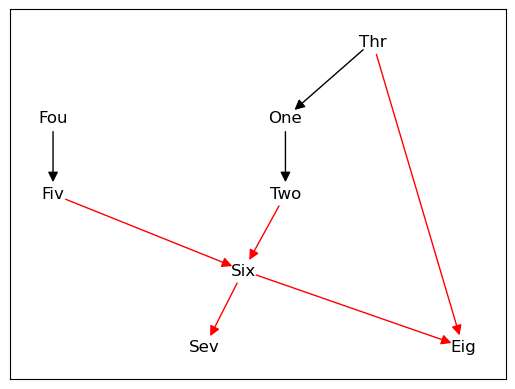

In [89]:
s_small = Gobnilp()
s_small.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')